In [ ]:
# # !pip uninstall matplotlib
# !pip install matplotlib==3.1.1

In [ ]:
# from __future__ import (absolute_import, division, print_function,
#                         unicode_literals)

# import backtrader as bt

# if __name__ == '__main__':
#     cerebro = bt.Cerebro()

#     print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

#     cerebro.run()

#     print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

In [1]:
!pip install backtrader
!pip install numpy
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

In [2]:
import datetime
import yfinance as yf
import backtrader as bt
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np

In [3]:
!pip install ipympl
!pip install nodejs-bin
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter labextension install jupyter-matplotlib

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir] [--paths] [--json]
               [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: bundlerextension console dejavu execute kernel kernelspec migrate nbclassic
nbconvert nbextension notebook run server serverextension troubleshoot trust

Jupyter command `jupyter-labextension` not found.
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir] [--paths] [

In [4]:
cerebro = bt.Cerebro()
cerebro.broker.setcash(10000.0)

In [5]:
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00


In [6]:
#Reading the Data
price_df_addr= "/content/daily-2020.csv"
price_df = pd.read_csv(
    price_df_addr,
    usecols=["timestamp", "close", "open", "high", "low", "volume"],
)
price_df.set_index("timestamp", inplace=True)
price_df.index = pd.to_datetime(price_df.index, unit="s")

price_df

,open,high,low,close,volume
timestamp,,,,,
2020-01-01,7189.43,7260.43,7170.15,7197.57,56801.329
2020-01-02,7197.57,7209.59,6922.00,6962.04,115295.677
2020-01-03,6962.34,7407.28,6863.44,7341.72,208493.458
2020-01-04,7341.60,7400.00,7269.21,7350.71,92586.033
2020-01-05,7350.54,7495.00,7303.00,7354.36,117765.972
...,...,...,...,...,...
2020-12-27,26508.84,28459.84,25850.00,26305.64,540264.148
2020-12-28,26301.76,27538.82,26117.10,27102.66,267563.468
2020-12-29,27101.45,27441.73,25913.01,27402.83,260759.449


In [7]:

# price_df = yf.download('AAPL', start = '2015-01-01')
# price_df

In [8]:
def model_predict(df):
    # Calculate short and long moving averages
    df.loc[:, 'short_mavg'] = df['close'].rolling(window=10).mean()
    df.loc[:, 'long_mavg'] = df['close'].rolling(window=30).mean()

    # Initialize the signal column to 0 (Hold)
    df.loc[:, 'signal'] = 0

    # Generate Buy signals
    df.loc[df['short_mavg'] > df['long_mavg'], 'signal'] = 1  # Buy

    # Generate Sell signals
    df.loc[df['short_mavg'] < df['long_mavg'], 'signal'] = -1  # Sell

    return df['signal']

In [9]:
price_df['signal'] = model_predict(price_df)

In [10]:
price_df['signal']

,signal
timestamp,
2020-01-01,0
2020-01-02,0
2020-01-03,0
2020-01-04,0
2020-01-05,0
...,...
2020-12-27,1
2020-12-28,1
2020-12-29,1


In [11]:
class PandasDataWithSignal(bt.feeds.PandasData):
    lines = ('signal',)
    params = (
        ('datetime', None),
        ('open', -1),
        ('high', -1),
        ('low', -1),
        ('close', -1),
        ('volume', -1),
        ('openinterest', -1),
        ('signal', -1),
    )

feed = PandasDataWithSignal(dataname=price_df)


In [12]:
cerebro.adddata(feed)

In [13]:
class ModelStrategy(bt.Strategy):
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.signal = self.datas[0].signal
        self.order = None  # Keep track of pending orders

    def next(self):
        current_signal = self.signal[0]  # Access the current value of the signal
        print(f"Signal: {current_signal}, Close: {self.dataclose[0]}")  # Print signal value

        if self.order:  # If there is a pending order, do nothing
          return

        # If the signal is BUY
        if current_signal == 1:
            if self.position.size < 0:  # If we're short, close the short position
                self.close()
                print(f"Closing short position at {self.dataclose[0]}")
                print('Portfolio Value: %.2f' % cerebro.broker.getvalue())
            if self.position.size == 0:
                self.buy()  # Enter long or add to existing long position
                print(f"Buying at {self.dataclose[0]}")
            else :
                print("Continue Holding - Buy signal")
            print('Portfolio Value: %.2f' % cerebro.broker.getvalue())

        # If the signal is SELL
        elif current_signal == -1:
            if self.position.size > 0:  # If we're long, close the long position
                self.close()
                print(f"Closing long position at {self.dataclose[0]}")
                print('Portfolio Value: %.2f' % cerebro.broker.getvalue())
            if self.position.size == 0:
                self.sell()  # Enter short or add to existing short position
                print(f"Selling at {self.dataclose[0]}")
            else :
                print("Continue Holding - Sell signal")
            print('Portfolio Value: %.2f' % cerebro.broker.getvalue())

        # HOLD does nothing
        elif current_signal == 0:
            print("Holding position")
            print('Portfolio Value: %.2f' % cerebro.broker.getvalue())

        print(f"Current position size: {self.position.size}")

In [14]:
print(price_df[['close', 'short_mavg', 'long_mavg', 'signal']].tail(20))


               close  short_mavg     long_mavg  signal
timestamp                                             
2020-12-12  18800.00   18773.630  18202.452000       1
2020-12-13  19175.07   18747.707  18297.603000       1
2020-12-14  19270.70   18808.357  18404.476000       1
2020-12-15  19424.91   18836.086  18520.230667       1
2020-12-16  21346.80   19033.264  18674.888333       1
2020-12-17  22816.99   19397.675  18846.454333       1
2020-12-18  23124.35   19878.178  19024.322000       1
2020-12-19  23847.28   20409.108  19225.508667       1
2020-12-20  23472.96   20931.053  19385.797000       1
2020-12-21  22730.10   21400.916  19519.400667       1
2020-12-22  23826.99   21903.615  19699.127000       1
2020-12-23  23238.27   22309.935  19861.000333       1
2020-12-24  23737.44   22756.609  20012.927000       1
2020-12-25  24730.00   23287.118  20212.538000       1
2020-12-26  26508.83   23803.321  20524.321000       1
2020-12-27  26305.64   24152.186  20829.705667       1
2020-12-28

In [15]:
# # Create a subclass of Strategy to define the indicators and logic

# class SmaCross(bt.Strategy):
#     def __init__(self):
#         sma1 = bt.ind.SMA(period=50)  # fast moving average
#         sma2 = bt.ind.SMA(period=100)  # slow moving average
#         self.crossover = bt.ind.CrossOver(sma1, sma2)  # crossover signal

#     def next(self):
#         if not self.position:  # not in the market
#             if self.crossover > 0:  # if fast crosses slow to the upside
#                 self.buy()  # enter long

#         elif self.crossover < 0:  # in the market & cross to the downside
#             self.close()  # close long position


In [16]:
# cerebro.addstrategy(SmaCross)
cerebro.addstrategy(ModelStrategy)

0

In [17]:
cerebro.broker.setcommission(commission= 0.005)

In [18]:
cerebro.addsizer(bt.sizers.PercentSizer, percents=50)

In [19]:
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe_ratio')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annual_return')

In [20]:
teststrat = cerebro.run()

Signal: 0.0, Close: 7197.57
Holding position
Portfolio Value: 10000.00
Current position size: 0
Signal: 0.0, Close: 6962.04
Holding position
Portfolio Value: 10000.00
Current position size: 0
Signal: 0.0, Close: 7341.72
Holding position
Portfolio Value: 10000.00
Current position size: 0
Signal: 0.0, Close: 7350.71
Holding position
Portfolio Value: 10000.00
Current position size: 0
Signal: 0.0, Close: 7354.36
Holding position
Portfolio Value: 10000.00
Current position size: 0
Signal: 0.0, Close: 7757.39
Holding position
Portfolio Value: 10000.00
Current position size: 0
Signal: 0.0, Close: 8152.49
Holding position
Portfolio Value: 10000.00
Current position size: 0
Signal: 0.0, Close: 8059.84
Holding position
Portfolio Value: 10000.00
Current position size: 0
Signal: 0.0, Close: 7818.59
Holding position
Portfolio Value: 10000.00
Current position size: 0
Signal: 0.0, Close: 8207.09
Holding position
Portfolio Value: 10000.00
Current position size: 0
Signal: 0.0, Close: 8020.56
Holding posi

In [21]:
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Final Portfolio Value: 23735.74


<IPython.core.display.Javascript object>

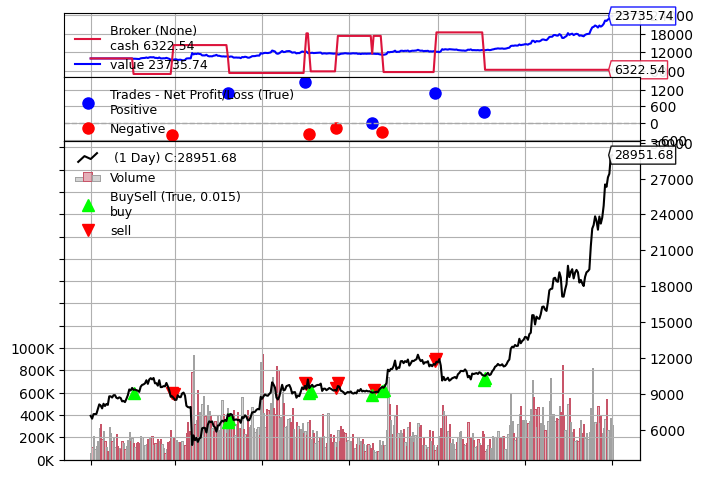

In [22]:
abc = cerebro.plot()
abc[0][0]

Showing analysis metrics

In [23]:
teststrat[0].analyzers.sharpe_ratio.riskfreerate=0.02
# teststrat[0].analyzers.sharpe_ratio.timeframe=bt.TimeFrame.Days
teststrat[0].analyzers.sharpe_ratio.compression=1
# teststrat[0].analyzers.sharpe_ratio.convertrate=True
teststrat[0].analyzers.sharpe_ratio.factor=252
# teststrat[0].analyzers.sharpe_ratio.stddev_sample=False
# teststrat[0].analyzers.sharpe_ratio.fund=100


teststrat[0].analyzers.sharpe_ratio.annualize=True
aaa = teststrat[0]
aaa.analyzers.sharpe_ratio.get_analysis()
#This analyzer is sensitive to ratio and number of trades, so it can return None when we don't have enough trades

OrderedDict([('sharperatio', None)])

In [24]:
#Manually implementing Sharpe Ratio:

# Extract returns from the TimeReturn analyzer
returns = np.array(list(teststrat[0].analyzers.time_return.get_analysis().values()))

# Calculate mean and standard deviation of returns
mean_return = np.mean(returns)
stddev_return = np.std(returns, ddof=1)  # ddof=1 gives sample standard deviation

# Risk-free rate (adjust to match your scenario)
risk_free_rate = 0.02 / 252  # Daily risk-free rate (assuming 252 trading days in a year)

# Calculate Sharpe Ratio
sharpe_ratio_manual = (mean_return - risk_free_rate) / stddev_return

print("Manual Sharpe Ratio:", sharpe_ratio_manual)

Manual Sharpe Ratio: 0.13309342826888038


In [25]:
# teststrat[0].analyzers.drawdown.get_analysis()

In [26]:
# teststrat[0].analyzers.returns.get_analysis()

OrderedDict([('rtot', 0.8643966986810611),
             ('ravg', 0.0023617396138826807),
             ('rnorm', 0.8133181204347795),
             ('rnorm100', 81.33181204347795)])

In [27]:
# teststrat[0].analyzers.time_return.get_analysis()

OrderedDict([(datetime.datetime(2020, 1, 1, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 2, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 3, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 4, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 5, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 6, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 7, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 8, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 9, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 10, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 11, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 12, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 13, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 14, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 15, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 16, 0, 0), 0.0),
             (datetime.datetime(2020, 1, 17, 0, 0), 0.0),
             (datetime.

In [28]:
# teststrat[0].analyzers.annual_return.get_analysis()

OrderedDict([(2020, 1.373573673804477)])